# Reproducing Hazard Curves from Nath & Thingbaijam (2012)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Given an occurrence rate $\lambda$ in a given time span $T_1$ and assuming a Poissonian process, the probability of one or more occurrences $P_1$ is

$P_1 = 1 - e ^{-\lambda T_1}$

so given a probability of exceedence, we can compute the rate 

$\lambda = \frac{-1}{T_1} \ln(1 - P_1)$

and work out the probability of exceedence for a different time period.

$P_2 = 1 - e ^{-\lambda T_2}$


In [2]:
import os
import codecs
import shutil
import warnings
from glob import glob

from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from scipy import interpolate

import numpy as np
import pandas as pd

from toolbox import logspace, annotate, read_hazard_csv

In [3]:
def convert_probability(poe_old, T_old, T_new=1):
    return 1 - np.exp(T_new/T_old*np.log(1 - poe_old))

In [4]:
def anonymize(file_name):
    if isinstance(file_name, list):
        return [anonymize(item) for item in file_name]
    return os.path.abspath(file_name).replace(os.path.expanduser('~'), '~')

In [5]:
NATH_PATH = '../Data/nath2012probabilistic'
DIGITIZED_PATH = '../Data/nath2012probabilistic/Figure6'
SITES_CSV = 'NT2012_Table_3_lon_lat.csv'
MAP_CSV = 'NT2012_Figure_7_Indian_subcontinent_lon_lat.csv'
FIGURE_FILE = 'Figure_6_Reproduced.pdf'
TABLE_FILE = 'Table_3_Reproduced.tex'
PLOT_CITIES = np.array([['Bangalore', 'Bhuj', 'Chennai'],
                        ['Guwahati', 'Jabalpur', 'Kolkata'],
                        ['Koyna', 'Mumbai', 'New Delhi'],
                        ['Kathmandu', 'Chandigarh', 'Islamabad']])
T_PLOT = 1  # year

## Job Setup

In [6]:
sites_table = os.path.join(NATH_PATH, 'Table 3.csv')
df_table3 = pd.read_csv(sites_table, skiprows=1, index_col='City')
df_table3

,Latitude (°N),Longitude (°E),BIS,zone,GSHAP,Present,Other,Reference
City,,,,,,,,
Ahmedabad,23.030000,72.610000,0.08,III,0.05,0.11,0.1,Jaiswal and Sinha 2007†
Bangalore,12.980000,77.580000,0.05,II,0.05,0.11,0.10; 0.15,Jaiswal and Sinha 2007†; Anbazhagan et al. 2009
Bhuj,23.250000,69.660000,0.18,V,0.20,0.42,0.25; 0.20-0.70,Jaiswal and Sinha 2007†; Petersen et al. 2004‡
Chennai,13.000000,80.180000,0.08,III,0.05,0.12,0.089; 0.10,Menon et al. 2010; Jaiswal and Sinha 2007†
Dehradun,30.330000,78.040000,0.12,IV,0.30,0.47,0.45,Mahajan et al. 2010
Guwahati,26.180000,91.730000,0.18,V,0.30,0.66,0.5,Sharma and Malik 2006
Hyderabad,17.450000,78.460000,0.05,II,0.05,0.09,0.08,Jaiswal and Sinha 2007†
Imphal,24.780000,93.940000,0.18,V,0.45,0.68,0.5,Sharma and Malik 2006
Jabalpur,23.200000,79.950000,0.08,III,0.10,0.19,0.15,Jaiswal and Sinha 2007†


In [7]:
df_sites = df_table3[['Longitude (°E)', 'Latitude (°N)']]
print('sites_csv = %s' % SITES_CSV)
df_sites.to_csv(SITES_CSV, header=False, index=False, float_format='%g')

sites_csv = NT2012_Table_3_lon_lat.csv


In [8]:
map_tables = ['India_pga.csv', 'India_psa_pt2sec.csv', 'India_psa_1sec.csv']
map_table_list = [os.path.join(NATH_PATH, item) for item in map_tables]
map_table_df_list = [pd.read_csv(file_name) for file_name in map_table_list]
df_map = map_table_df_list[0][['lon', 'lat']]
print('map_csv = %s' % MAP_CSV)
df_map.to_csv(MAP_CSV, header=False, index=False, float_format='%g')

map_csv = NT2012_Figure_7_Indian_subcontinent_lon_lat.csv


In [9]:
poes_nom = np.array([0.1, 0.02])
T_nom = 50  # years
poes_plot = convert_probability(poes_nom, T_nom, T_PLOT)
poe_labels = ['%g%% in %g year' % (100*poe, T_nom) for poe in poes_nom]

print('investigation time: %g year' % T_PLOT)
print('poes = %s' % ' '.join(['%.5g' % poe for poe in poes_plot]))
print(poe_labels)

investigation time: 1 year
poes = 0.002105 0.00040397
['10% in 50 year', '2% in 50 year']


In [10]:
imts = ['PGA', 'SA(0.2)', 'SA(1.0)']
gmls = logspace(.004, 10, 12)
print('intensity_measure_types_and_levels = {')
for imt in imts:
    print('    "%s": [%s]' % (imt, ', '.join('%g' % gml for gml in gmls)))
print('}')

intensity_measure_types_and_levels = {
    "PGA": [0.0047, 0.0056, 0.0068, 0.0082, 0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.033, 0.039, 0.047, 0.056, 0.068, 0.082, 0.1, 0.12, 0.15, 0.18, 0.22, 0.27, 0.33, 0.39, 0.47, 0.56, 0.68, 0.82, 1, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2, 10]
    "SA(0.2)": [0.0047, 0.0056, 0.0068, 0.0082, 0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.033, 0.039, 0.047, 0.056, 0.068, 0.082, 0.1, 0.12, 0.15, 0.18, 0.22, 0.27, 0.33, 0.39, 0.47, 0.56, 0.68, 0.82, 1, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2, 10]
    "SA(1.0)": [0.0047, 0.0056, 0.0068, 0.0082, 0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.033, 0.039, 0.047, 0.056, 0.068, 0.082, 0.1, 0.12, 0.15, 0.18, 0.22, 0.27, 0.33, 0.39, 0.47, 0.56, 0.68, 0.82, 1, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2, 10]
}


## Post-Processing

First compare to published results.

In [11]:
curve_files_new = sorted([
    os.path.abspath(item) for item in glob(os.path.join('cities_collapsed_v2', '*24348*.csv'))
    if all(key in item for key in ['hazard_curve-', 'mean'])])
curve_files_new = [item for item in curve_files_new if any(im_type in item for im_type in imts)]
anonymize(curve_files_new)

['~/src/indian-subcontinent-psha/Results/cities_collapsed_v2/hazard_curve-mean-PGA_24348.csv',
 '~/src/indian-subcontinent-psha/Results/cities_collapsed_v2/hazard_curve-mean-SA(0.2)_24348.csv',
 '~/src/indian-subcontinent-psha/Results/cities_collapsed_v2/hazard_curve-mean-SA(1.0)_24348.csv']

Kathmandu_PGA.csv not found ...


/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Kathmandu_SA(0.2).csv not found ...
Kathmandu_SA(1).csv not found ...


'~/src/indian-subcontinent-psha/Results/Figure_6_Reproduced.pdf'

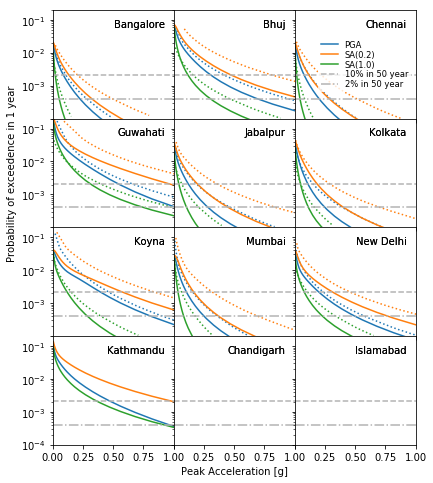

In [12]:
fig, axes = plt.subplots(PLOT_CITIES.shape[0], PLOT_CITIES.shape[1], 
                         figsize=(6.5, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for curve_file in curve_files_new:
    poes, config = read_hazard_csv(curve_file)
    label = os.path.split(curve_file)[1]
       
    if config['imt'] == 'PGV':
        warnings.warn('IMT %s units not properly reflected in axis label.' % 
                      config['imt'], UserWarning)
        
    poes = poes.apply(
        lambda x: convert_probability(x, config['investigation_time'], T_PLOT))
        
    for (lon, lat, _), data in poes.iterrows():
        in_table3 = ((df_table3['Longitude (°E)'] == lon) & 
                     (df_table3['Latitude (°N)'] == lat))
        
        if any(in_table3):
            city = in_table3.idxmax()
        else:
            print('Unknown site at %g°N %g°E. Ignoring ...' % (lat, lon))
            continue
            
        if city in PLOT_CITIES:
            ax = axes[PLOT_CITIES == city][0]
            trace = ax.semilogy(data.index, data.values, label=config['imt'])
            
            digitized_csv = '%s_%s.csv' % (city.replace(' ','_'), 
                                           config['imt'].replace('.0', ''))
            digitized_full = os.path.join(DIGITIZED_PATH, digitized_csv)
            if os.path.isfile(digitized_full):
                data = np.genfromtxt(digitized_full, delimiter=',')
                ax.plot(data[:, 0], data[:, 1], 
                        linestyle=':', color=trace[0].get_color())
            else:
                print('%s not found ...' % digitized_csv)

# add reference curves and set limits
for ax, city in zip(axes.ravel(), PLOT_CITIES.ravel()):
    ax.set_xlim((0, 1))
    ax.set_ylim((1e-4, 0.2))
    for prob, label, linestyle in zip(poes_plot, poe_labels, ['--', '-.', ':']):
        ax.axhline(prob, label=label, color='0.7', linestyle=linestyle)
        fig.sca(ax)
        annotate(city, loc='upper right')
    
axes[1,0].set_ylabel(
    'Probability of exceedence in %g year%s' % 
    (T_PLOT, '' if T_PLOT == 1 else 's'))
[ax.yaxis.get_major_ticks()[1].label.set_visible(False) for ax in axes[:-1,0]]
axes[-1,1].set_xlabel('Peak Acceleration [g]')
[ax.xaxis.get_major_ticks()[0].label.set_visible(False) for ax in axes[-1,1:]]
leg = axes[0,-1].legend(loc='center right', frameon=True, fontsize='small', labelspacing=0.1)
leg.get_frame().set_linewidth(0.0)

fig.savefig(FIGURE_FILE, dpi=600, bbox_inches='tight')
anonymize(FIGURE_FILE)

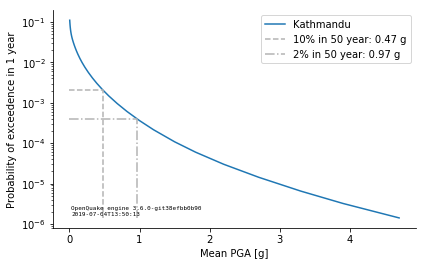

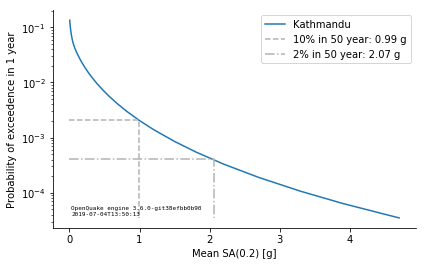

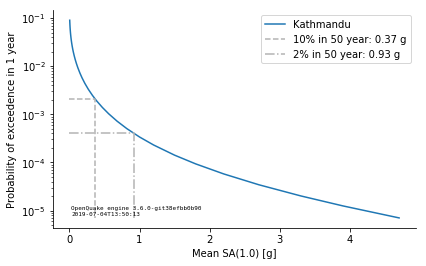

In [13]:
for curve_file in curve_files_new:
    poes, config = read_hazard_csv(curve_file)
    config.pop('checksum')
    config['source'] = config.pop('# generated_by')
    T_inv = config.pop('investigation_time')
    kind = config.pop('kind')
    imt = config.pop('imt')
    units = 'cm/s' if imt == 'PGV' else 'g'
    city = df_table3.loc['Kathmandu']
    poes_series = poes.loc[(city['Longitude (°E)'], city['Latitude (°N)'], 0)]
    poes_series = poes_series.apply(lambda x: convert_probability(x, T_inv, T_PLOT))
    poes_series.name = city.name

    fig, ax = plt.subplots(figsize=(6.5, 4))
    poes_series.plot(logy=True, ax=ax)

    for prob, label, linestyle in zip(poes_plot, poe_labels, ['--', '-.', ':']):
        interpolator = interpolate.interp1d(poes_series.values[::-1], poes_series.index[::-1], fill_value='extrapolate')
        intensity = interpolator(prob)
        ax.plot([0, intensity, intensity],
                [prob, prob, poes_series.min()],
                label='%s: %.2f g' % (label, intensity), 
                color='0.7', linestyle=linestyle)

    ax.annotate('\n'.join(pd.Series(config).sort_index().values),
                xy=(0.05, 0.05), xycoords='axes fraction', va='bottom', ha='left', 
                fontsize=6, family='monospace')
    ax.set_ylabel(
        'Probability of exceedence in %g year%s' % 
        (T_PLOT, '' if T_PLOT == 1 else 's'))
    ax.set_xlabel('%s %s [%s]' % (kind.title(), imt, units))
    ax.legend()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.savefig(city.name + '_' + imt + '.png', dpi=300, bbox_inches='tight')

In [14]:
map_files = sorted([
    item for item in glob(os.path.join('cities_collapsed_v2', '*.csv'))
    if all(key in item for key in ['hazard_map-', 'mean'])])
anonymize(map_files)

['~/src/indian-subcontinent-psha/Results/cities_collapsed_v2/hazard_map-mean_24348.csv']

In [15]:
map_file = map_files[0]
column = 'PGA-0.1'
df_pga = pd.read_csv(map_file, header=1)
df_pga = df_pga[['lon', 'lat', column]]

df_cities = df_table3.copy()
df_cities.rename(
    columns={'Longitude (°E)': 'lon', 'Latitude (°N)': 'lat'},
    inplace=True)

df_compare = pd.merge(df_cities[['lon', 'lat', 'Present']].reset_index(), df_pga, on=['lon', 'lat'])
df_compare.dropna(subset=['Present'], inplace=True)
df_compare.drop(columns=['lon', 'lat'], inplace=True)
df_compare.set_index('City', inplace=True)
df_compare.rename(columns={
    'Present': 'NT2012 [g]', 
    column: 'A2018 [g]'}, inplace=True)
df_compare['Error [g]'] = (df_compare['A2018 [g]'] - 
                           df_compare['NT2012 [g]']).round(2)
df_compare['Error [%]'] = (100*(df_compare['A2018 [g]']/
                                df_compare['NT2012 [g]'] - 1)).round()
df_compare['A2018 [g]'] = df_compare['A2018 [g]'].round(3)
# df_compare.sort_values('Error [%]', ascending=False, inplace=True)
display(df_compare)

df_compare.columns = pd.MultiIndex.from_tuples(
    [tuple(item.split()) for item in df_compare.columns])
with codecs.open(TABLE_FILE, 'w', 'utf-8') as file_object:
    df_compare.to_latex(file_object, index=True)
anonymize(shutil.copyfile(TABLE_FILE, os.path.splitext(map_file)[0] + '.tex'))

,NT2012 [g],A2018 [g],Error [g],Error [%]
City,,,,
Ahmedabad,0.11,0.064,-0.05,-41.0
Bangalore,0.11,0.087,-0.02,-21.0
Bhuj,0.42,0.306,-0.11,-27.0
Chennai,0.12,0.079,-0.04,-35.0
Dehradun,0.47,0.268,-0.20,-43.0
Guwahati,0.66,0.539,-0.12,-18.0
Hyderabad,0.09,0.068,-0.02,-25.0
Imphal,0.68,0.695,0.01,2.0
Jabalpur,0.19,0.120,-0.07,-37.0


'~/src/indian-subcontinent-psha/Results/cities_collapsed_v2/hazard_map-mean_24348.tex'

Now compare using map output (because generalizable to any location).

In [16]:
curve_files_new = sorted([
    os.path.abspath(item) for item in glob(os.path.join('map_collapsed_v2', '*.csv'))
    if all(key in item for key in ['hazard_curve-', 'mean'])])
[anonymize(item) for item in curve_files_new]

['~/src/indian-subcontinent-psha/Results/map_collapsed_v2/hazard_curve-mean-PGA_24323.csv',
 '~/src/indian-subcontinent-psha/Results/map_collapsed_v2/hazard_curve-mean-SA(0.2)_24323.csv',
 '~/src/indian-subcontinent-psha/Results/map_collapsed_v2/hazard_curve-mean-SA(1.0)_24323.csv']

Kathmandu_PGA.csv not found ...
Chandigarh_PGA.csv not found ...
No site found near Islamabad at 33.8°N, 73°E
Kathmandu_SA(0.2).csv not found ...
Chandigarh_SA(0.2).csv not found ...
No site found near Islamabad at 33.8°N, 73°E
Kathmandu_SA(1).csv not found ...
Chandigarh_SA(1).csv not found ...
No site found near Islamabad at 33.8°N, 73°E


'~/src/indian-subcontinent-psha/Results/Figure_6_Reproduced.pdf'

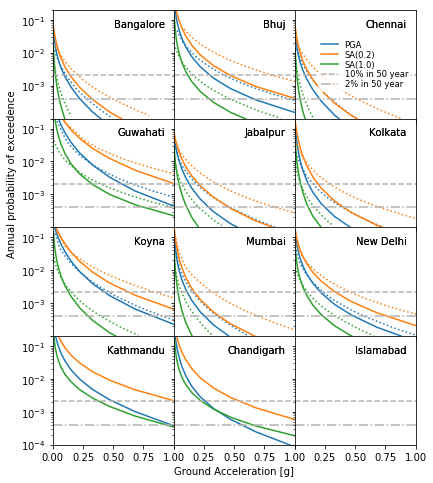

In [17]:
fig, axes = plt.subplots(PLOT_CITIES.shape[0], PLOT_CITIES.shape[1], 
                         figsize=(6.5, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for curve_file in curve_files_new:
    poes, config = read_hazard_csv(curve_file)
    label = os.path.split(curve_file)[1]
    
    poes = poes.apply(
        lambda x: convert_probability(x, config['investigation_time'], T_PLOT))

    if config['imt'] == 'PGV':
        warnings.warn('IMT %s units not properly reflected in axis label.' % 
                      config['imt'], UserWarning)
        
    for city_row, axes_row in zip(PLOT_CITIES, axes):
        for city, ax in zip(city_row, axes_row):
            city_series = df_table3.loc[city]
            lon = round(round(5*city_series['Longitude (°E)'])/5, 1)
            lat = round(round(5*city_series['Latitude (°N)'])/5, 1)
            if (lon, lat, 0) in poes.index:
                poes_city = poes.loc[(lon, lat, 0)]

                trace = ax.semilogy(poes_city.index, poes_city.values, 
                                    label=config['imt'])

                digitized_csv = '%s_%s.csv' % (city.replace(' ','_'), config['imt'].replace('.0', ''))
                digitized_full = os.path.join(DIGITIZED_PATH, digitized_csv)
                if os.path.isfile(digitized_full):
                    data = np.genfromtxt(digitized_full, delimiter=',')
                    ax.plot(data[:, 0], data[:, 1], 
                            linestyle=':', color=trace[0].get_color())
                else:
                    print('%s not found ...' % digitized_csv)
            else:
                print('No site found near %s at %g°N, %g°E' % (city, lat, lon))

# add reference curves and set limits
for ax, city in zip(axes.ravel(), PLOT_CITIES.ravel()):
    ax.set_xlim((0, 1))
    ax.set_ylim((1e-4, 0.2))
    for prob, label, linestyle in zip(poes_plot, poe_labels, ['--', '-.', ':']):
        ax.axhline(prob, label=label, color='0.7', linestyle=linestyle)
        fig.sca(ax)
        annotate(city, loc='upper right')
    
axes[1,0].set_ylabel('Annual probability of exceedence')
[ax.yaxis.get_major_ticks()[1].label.set_visible(False) for ax in axes[:-1,0]]
axes[-1,1].set_xlabel('Ground Acceleration [g]')
[ax.xaxis.get_major_ticks()[0].label.set_visible(False) for ax in axes[-1,1:]]
leg = axes[0,-1].legend(loc='center right', frameon=True, fontsize='small', labelspacing=0.1)
leg.get_frame().set_linewidth(0.0)

fig.savefig(FIGURE_FILE, dpi=600, bbox_inches='tight')
anonymize(FIGURE_FILE)

In [18]:
curve_files_old = sorted([
    os.path.abspath(item) for item in glob(os.path.join('map_collapsed_v1', '*360*.csv'))
    if all(key in item for key in ['hazard_curve-', 'mean'])])
curve_files_old = [item for item in curve_files_old if any(im_type in item for im_type in imts)]
[anonymize(item) for item in curve_files_old]

['~/src/indian-subcontinent-psha/Results/map_collapsed_v1/hazard_curve-mean-PGA_360.csv',
 '~/src/indian-subcontinent-psha/Results/map_collapsed_v1/hazard_curve-mean-SA(0.2)_360.csv',
 '~/src/indian-subcontinent-psha/Results/map_collapsed_v1/hazard_curve-mean-SA(1.0)_360.csv']

Kathmandu_PGA.csv not found ...
Chandigarh_PGA.csv not found ...
No site found near Islamabad at 33.8°N, 73°E
Kathmandu_SA(0.2).csv not found ...
Chandigarh_SA(0.2).csv not found ...
No site found near Islamabad at 33.8°N, 73°E
Kathmandu_SA(1).csv not found ...
Chandigarh_SA(1).csv not found ...
No site found near Islamabad at 33.8°N, 73°E


'~/src/indian-subcontinent-psha/Results/Figure_6_Reproduced.pdf'

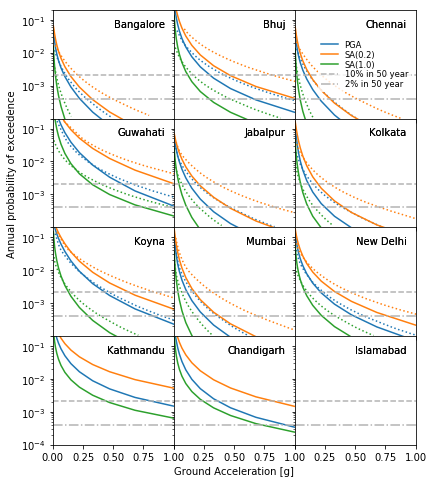

In [19]:
fig, axes = plt.subplots(PLOT_CITIES.shape[0], PLOT_CITIES.shape[1], 
                         figsize=(6.5, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for curve_file in curve_files_old:
    poes, config = read_hazard_csv(curve_file)
    label = os.path.split(curve_file)[1]
    
    poes = poes.apply(
        lambda x: convert_probability(x, config['investigation_time'], T_PLOT))

    if config['imt'] == 'PGV':
        warnings.warn('IMT %s units not properly reflected in axis label.' % 
                      config['imt'], UserWarning)
        
    for city_row, axes_row in zip(PLOT_CITIES, axes):
        for city, ax in zip(city_row, axes_row):
            city_series = df_table3.loc[city]
            lon = round(round(5*city_series['Longitude (°E)'])/5, 1)
            lat = round(round(5*city_series['Latitude (°N)'])/5, 1)
            if (lon, lat, 0) not in poes.index:
                print('No site found near %s at %g°N, %g°E' % (city, lat, lon))
                continue
                
            poes_city = poes.loc[(lon, lat, 0)]
            trace = ax.semilogy(poes_city.index, poes_city.values, 
                                label=config['imt'])

            digitized_csv = '%s_%s.csv' % (city.replace(' ','_'), config['imt'].replace('.0', ''))
            digitized_full = os.path.join(DIGITIZED_PATH, digitized_csv)
            
            if not os.path.isfile(digitized_full):
                print('%s not found ...' % digitized_csv)
                continue
                
            data = np.genfromtxt(digitized_full, delimiter=',')
            ax.plot(data[:, 0], data[:, 1], 
                    linestyle=':', color=trace[0].get_color())
           

# add reference curves and set limits
for ax, city in zip(axes.ravel(), PLOT_CITIES.ravel()):
    ax.set_xlim((0, 1))
    ax.set_ylim((1e-4, 0.2))
    for prob, label, linestyle in zip(poes_plot, poe_labels, ['--', '-.', ':']):
        ax.axhline(prob, label=label, color='0.7', linestyle=linestyle)
        fig.sca(ax)
        annotate(city, loc='upper right')
    
axes[1,0].set_ylabel('Annual probability of exceedence')
[ax.yaxis.get_major_ticks()[1].label.set_visible(False) for ax in axes[:-1,0]]
axes[-1,1].set_xlabel('Ground Acceleration [g]')
[ax.xaxis.get_major_ticks()[0].label.set_visible(False) for ax in axes[-1,1:]]
leg = axes[0,-1].legend(loc='center right', frameon=True, fontsize='small', labelspacing=0.1)
leg.get_frame().set_linewidth(0.0)

fig.savefig(FIGURE_FILE, dpi=600, bbox_inches='tight')
anonymize(FIGURE_FILE)

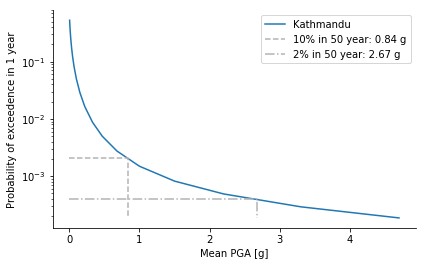

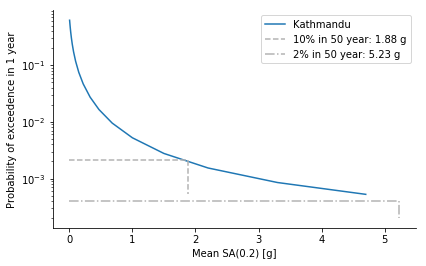

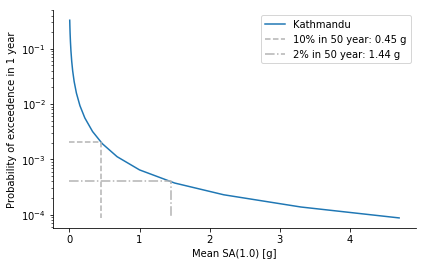

In [20]:
city = 'Kathmandu'
for curve_file in curve_files_old:
    poes, config = read_hazard_csv(curve_file)
    config.pop('checksum', None)
    config['source'] = config.pop('# generated_by', '')
    T_inv = config.pop('investigation_time')
    kind = config.pop('kind', 'mean')
    imt = config.pop('imt')
    units = 'cm/s' if imt == 'PGV' else 'g'

    city_series = df_table3.loc[city]
    lon = round(round(5*city_series['Longitude (°E)'])/5, 1)
    lat = round(round(5*city_series['Latitude (°N)'])/5, 1)
    if (lon, lat, 0) not in poes.index:
        raise RuntimeError('No site found near %s at %g°N, %g°E' % (city, lat, lon))

    poes_series = poes.loc[(lon, lat, 0)]
    poes_series = poes_series.apply(lambda x: convert_probability(x, T_inv, T_PLOT))
    poes_series.name = city

    fig, ax = plt.subplots(figsize=(6.5, 4))
    poes_series.plot(logy=True, ax=ax)

    for prob, label, linestyle in zip(poes_plot, poe_labels, ['--', '-.', ':']):
        interpolator = interpolate.interp1d(poes_series.values[::-1], poes_series.index[::-1], fill_value='extrapolate')
        intensity = interpolator(prob)
        ax.plot([0, intensity, intensity],
                [prob, prob, min(poes_series.min(), prob/2)],
                label='%s: %.2f g' % (label, intensity), 
                color='0.7', linestyle=linestyle)

    ax.annotate('\n'.join(pd.Series(config).sort_index().values),
                xy=(0.05, 0.05), xycoords='axes fraction', va='bottom', ha='left', 
                fontsize=6, family='monospace')
    ax.set_ylabel(
        'Probability of exceedence in %g year%s' % 
        (T_PLOT, '' if T_PLOT == 1 else 's'))
    ax.set_xlabel('%s %s [%s]' % (kind.title(), imt, units))
    ax.legend()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.savefig(city + '_' + imt + '_interp_old.png', dpi=300, bbox_inches='tight')

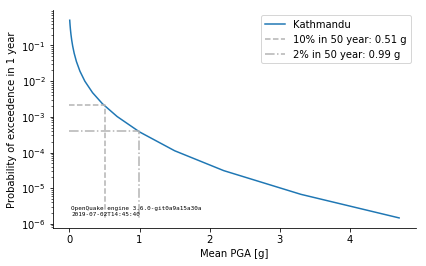

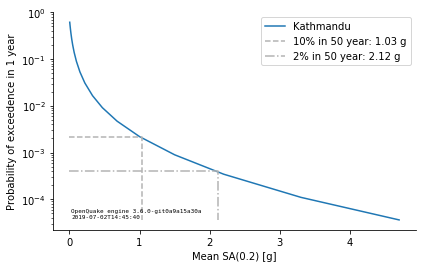

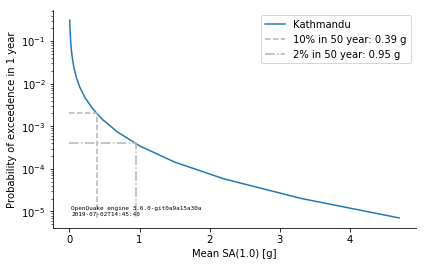

In [21]:
city = 'Kathmandu'
for curve_file in curve_files_new:
    poes, config = read_hazard_csv(curve_file)
    config.pop('checksum', None)
    config['source'] = config.pop('# generated_by', '')
    T_inv = config.pop('investigation_time')
    kind = config.pop('kind', 'mean')
    imt = config.pop('imt')
    units = 'cm/s' if imt == 'PGV' else 'g'

    city_series = df_table3.loc[city]
    lon = round(round(5*city_series['Longitude (°E)'])/5, 1)
    lat = round(round(5*city_series['Latitude (°N)'])/5, 1)
    if (lon, lat, 0) not in poes.index:
        raise RuntimeError('No site found near %s at %g°N, %g°E' % (city, lat, lon))

    poes_series = poes.loc[(lon, lat, 0)]
    poes_series = poes_series.apply(lambda x: convert_probability(x, T_inv, T_PLOT))
    poes_series.name = city

    fig, ax = plt.subplots(figsize=(6.5, 4))
    poes_series.plot(logy=True, ax=ax)

    for prob, label, linestyle in zip(poes_plot, poe_labels, ['--', '-.', ':']):
        interpolator = interpolate.interp1d(poes_series.values[::-1], poes_series.index[::-1], fill_value='extrapolate')
        intensity = interpolator(prob)
        ax.plot([0, intensity, intensity],
                [prob, prob, min(poes_series.min(), prob/2)],
                label='%s: %.2f g' % (label, intensity), 
                color='0.7', linestyle=linestyle)

    ax.annotate('\n'.join(pd.Series(config).sort_index().values),
                xy=(0.05, 0.05), xycoords='axes fraction', va='bottom', ha='left', 
                fontsize=6, family='monospace')
    ax.set_ylabel(
        'Probability of exceedence in %g year%s' % 
        (T_PLOT, '' if T_PLOT == 1 else 's'))
    ax.set_xlabel('%s %s [%s]' % (kind.title(), imt, units))
    ax.legend()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.savefig(city + '_' + imt + '_interp.png', dpi=300, bbox_inches='tight')